In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import datetime
import ccxt
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

/root/anaconda3/envs/torch/lib/python3.8/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
binance = ccxt.binance()
ohlcv = binance.fetch_ohlcv("BTC/USDT", "6h")
tweets = pd.read_csv("tweets_count.csv", encoding="utf-8")

sample = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
sample['datetime'] = pd.to_datetime(sample['datetime'], unit='ms')
sample.set_index('datetime', inplace=True)

In [3]:
tweets = pd.read_csv("tweets_count.csv", encoding="utf-8")
tweets["datetime"] = tweets["date_date"]
tweets.set_index('datetime', inplace=True)
tweets = tweets[["600", "1200", "1800", "2400"]]
tweets.head()



,600,1200,1800,2400
datetime,,,,
2021-02-05,0,99,907,688
2021-02-06,616,809,1066,787
2021-02-07,616,754,955,705
2021-02-08,505,689,2793,1660
2021-02-09,1164,1132,1178,876


In [4]:
sample['tweets'] = 0
for idx in tweets.index:
    dates = idx.split("-")
    dates = [int(x) for x in dates]
    pd_0to6 = pd.Timestamp(dates[0], dates[1], dates[2], 0, 0, 0)
    pd_6to12 = pd.Timestamp(dates[0], dates[1], dates[2], 6, 0, 0)
    pd_12to18 = pd.Timestamp(dates[0], dates[1], dates[2], 12, 0, 0)
    pd_18to24 = pd.Timestamp(dates[0], dates[1], dates[2], 18, 0, 0)

    sample.loc[pd_0to6, 'tweets'] = tweets.loc[idx, '600']
    sample.loc[pd_6to12, 'tweets'] = tweets.loc[idx, '1200']
    sample.loc[pd_12to18, 'tweets'] = tweets.loc[idx, '1800']
    sample.loc[pd_18to24, 'tweets'] = tweets.loc[idx, '2400']

In [5]:
# Use 10 frame for min and max
sample['number'] = sample.index.map(mdates.date2num)
sample['w_open'] = (sample['open'] - sample.rolling(window=10)['open'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_high'] = (sample['high'] - sample.rolling(window=10)['high'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_low'] = (sample['low'] - sample.rolling(window=10)['low'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_close'] = (sample['close'] - sample.rolling(window=10)['close'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_volume'] = (sample['volume'] - sample.rolling(window=10)['volume'].min()) / (sample.rolling(window=10)['volume'].max() - sample.rolling(window=10)['volume'].min())
sample['w_tweets'] = (sample['tweets'] - sample.rolling(window=10)['tweets'].min()) / (sample.rolling(window=10)['tweets'].max() - sample.rolling(window=10)['tweets'].min())
sample['label'] = (sample.shift(-1)['close'] - sample.shift(-1)['open'])/sample.shift(-1)['open'] > 0.0003

sample.head(50)

for idx in sample.index:
    if np.isnan(sample.loc[idx, "w_tweets"]):
        sample.loc[idx, "w_tweets"] = 0.
        # print(sample.loc[idx, "w_tweets"])
    else:
        pass

sample['rtn'] = sample['close'].pct_change()

sample.dropna(inplace=True)

# make train, validation, test samples
features = sample[["w_open", "w_high", "w_low", "w_volume", "w_tweets"]].to_numpy()
target = sample['label'].to_numpy()
target = np.array([int(x) for x in target])

X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)

In [6]:
clf = TPOTClassifier(generations=10, population_size=50, verbosity=2, random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
clf.export("tpot_pipeline.py")

Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6248796741947427

Generation 2 - Current best internal CV score: 0.6248796741947427

Generation 3 - Current best internal CV score: 0.6412439837097372

Generation 4 - Current best internal CV score: 0.6412439837097372

Generation 5 - Current best internal CV score: 0.6412439837097372

Generation 6 - Current best internal CV score: 0.6412439837097372

Generation 7 - Current best internal CV score: 0.6412439837097372

Generation 8 - Current best internal CV score: 0.6412439837097372

Generation 9 - Current best internal CV score: 0.6412439837097372

Generation 10 - Current best internal CV score: 0.6412439837097372

Best pipeline: XGBClassifier(input_matrix, learning_rate=1.0, max_depth=9, min_child_weight=11, n_estimators=100, n_jobs=1, subsample=0.6000000000000001, verbosity=0)
0.5284552845528455


In [16]:
from xgboost import XGBClassifier

exported_pipeline = XGBClassifier(learning_rate=1.0, max_depth=9, min_child_weight=11, n_estimators=100, n_jobs=1, subsample=0.6000000000000001, verbosity=0)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1.0, max_delta_step=0, max_depth=9,
              min_child_weight=11, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [17]:
sample['weight'] = 0.

# make weights
train_weights = [x[1] for x in exported_pipeline.predict_proba(X_train)]
test_weights = [x[1] for x in exported_pipeline.predict_proba(X_test)]

split = int(len(sample)*0.75)
train_sample = sample.iloc[:split]
test_sample = sample.iloc[split:]

train_sample['acc_rtn'] = (1. + train_sample['rtn']).cumprod()
test_sample['acc_rtn'] = (1. + test_sample['rtn']).cumprod()

for i, idx in enumerate(train_sample.index):
    train_sample.loc[idx, 'weight'] = train_weights[i]

for i, idx in enumerate(test_sample.index):
    test_sample.loc[idx, 'weight'] = test_weights[i]

In [18]:
train_book = train_sample[['number', 'close', 'weight']].copy()
train_book['rtn'] = 0.

for idx in train_book.index:
    if idx == train_book.index[0]:
        continue

    weight = train_book.loc[idx, 'weight']
    train_book.loc[idx, 'rtn'] = weight * (train_book.loc[idx, 'close'] / train_book.shift(1).loc[idx, 'close'] - 1.)

train_book['acc_rtn'] = (1. + train_book['rtn']).cumprod()

print(train_book.tail())

                       number     close    weight       rtn   acc_rtn
datetime                                                             
2021-05-01 06:00:00  18748.25  57816.90  0.602056 -0.003289  1.226098
2021-05-01 12:00:00  18748.50  57569.99  0.090865 -0.000388  1.225623
2021-05-01 18:00:00  18748.75  57800.37  0.554576  0.002219  1.228343
2021-05-02 00:00:00  18749.00  56902.07  0.602056 -0.009357  1.216849
2021-05-02 06:00:00  18749.25  57090.00  0.457895  0.001512  1.218690


In [19]:
test_book = test_sample[['number', 'close', 'weight']].copy()
test_book['rtn'] = 0.

for idx in test_book.index:
    if idx == test_book.index[0]:
        continue

    weight = test_book.loc[idx, 'weight']
    test_book.loc[idx, 'rtn'] = weight * (test_book.loc[idx, 'close'] / test_book.shift(1).loc[idx, 'close'] - 1.)

test_book['acc_rtn'] = (1. + test_book['rtn']).cumprod()

print(test_book.tail())

                       number     close    weight       rtn   acc_rtn
datetime                                                             
2021-06-01 00:00:00  18779.00  37266.55  0.882746  0.000302  0.827120
2021-06-01 06:00:00  18779.25  36596.62  0.016272 -0.000293  0.826878
2021-06-01 12:00:00  18779.50  36154.77  0.241644 -0.002917  0.824466
2021-06-01 18:00:00  18779.75  36693.09  0.372854  0.005552  0.829043
2021-06-02 00:00:00  18780.00  36717.77  0.538260  0.000362  0.829343


In [20]:
# evaluate
CAGR = train_sample['acc_rtn'].iloc[-1]**(365*4/len(train_sample.index)) - 1.
historical_max = train_sample['acc_rtn'].cummax()
daily_drawdown = train_sample['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(train_sample['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(train_sample['rtn'])/np.std(train_sample['rtn']))*np.sqrt(365*4)

print("==== Buy and hold ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}ß%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

CAGR = train_book['acc_rtn'].iloc[-1]**(365*4/len(train_book.index)) - 1.
historical_max = train_book['acc_rtn'].cummax()
daily_drawdown = train_book['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(train_book['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(train_book['rtn'])/np.std(train_book['rtn']))*np.sqrt(365*4)

print("==== RF Classifier ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

==== Buy and hold ====
CAGR: 713.36%
MDD: -25.01%
VOL: 80.72ß%
Sharpe: 300.17%
==== RF Classifier ====
CAGR: 119.17%
MDD: -19.82%
VOL: 47.51%
Sharpe: 188.91%


In [21]:
# evaluate
CAGR = test_sample['acc_rtn'].iloc[-1]**(365*4/len(test_sample.index)) - 1.
historical_max = test_sample['acc_rtn'].cummax()
daily_drawdown = test_sample['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(test_sample['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(test_sample['rtn'])/np.std(test_sample['rtn']))*np.sqrt(365*4)

print("==== Buy and hold ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}ß%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

CAGR = test_book['acc_rtn'].iloc[-1]**(365*4/len(test_book.index)) - 1.
historical_max = test_book['acc_rtn'].cummax()
daily_drawdown = test_book['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(test_book['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(test_book['rtn'])/np.std(test_book['rtn']))*np.sqrt(365*4)

print("==== RF Classifier ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

==== Buy and hold ====
CAGR: -99.47%
MDD: -44.61%
VOL: 116.87ß%
Sharpe: -388.43%
==== RF Classifier ====
CAGR: -89.15%
MDD: -27.97%
VOL: 59.01%
Sharpe: -346.65%


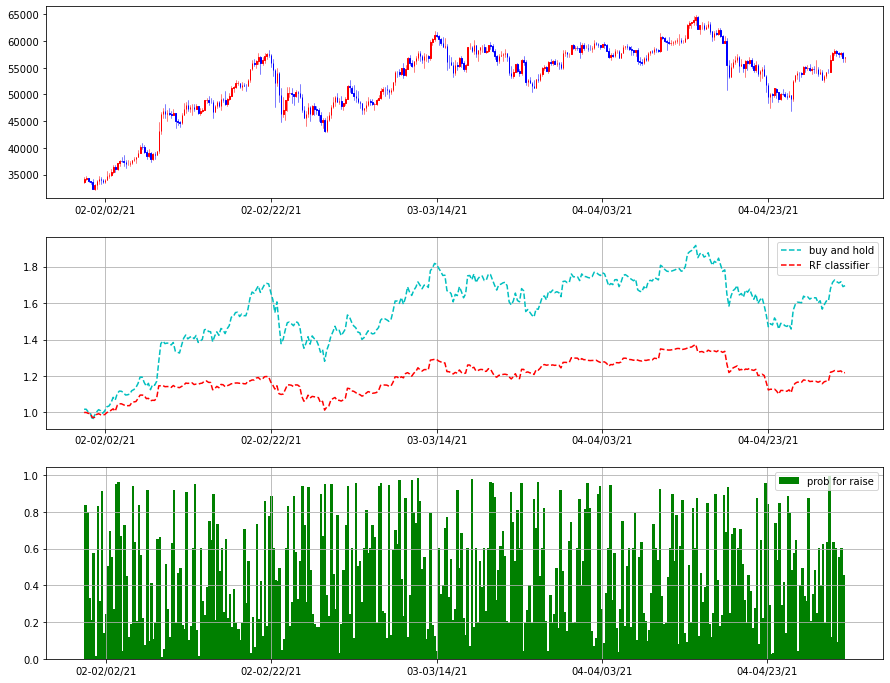

In [22]:
# let's see how the data looks like
ohlc = train_sample[['number', 'open', 'high', 'low', 'close']].copy()

plt.figure(figsize=(15, 12))
p1 = plt.subplot(3, 1, 1)
candlestick_ohlc(p1, ohlc.values, width=0.06, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))

p2 = plt.subplot(3, 1, 2)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.plot(train_sample.number, train_sample.acc_rtn, 'c--', label="buy and hold")
plt.plot(train_book.number, train_book.acc_rtn, 'r--', label='RF classifier')
plt.legend(loc='best')
plt.grid(True)

p3 = plt.subplot(3, 1, 3)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.bar(train_book.number, train_book.weight, color='g', width=0.3, label="prob for raise")
plt.legend(loc='best')
plt.yticks([0., 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(True)
plt.show()

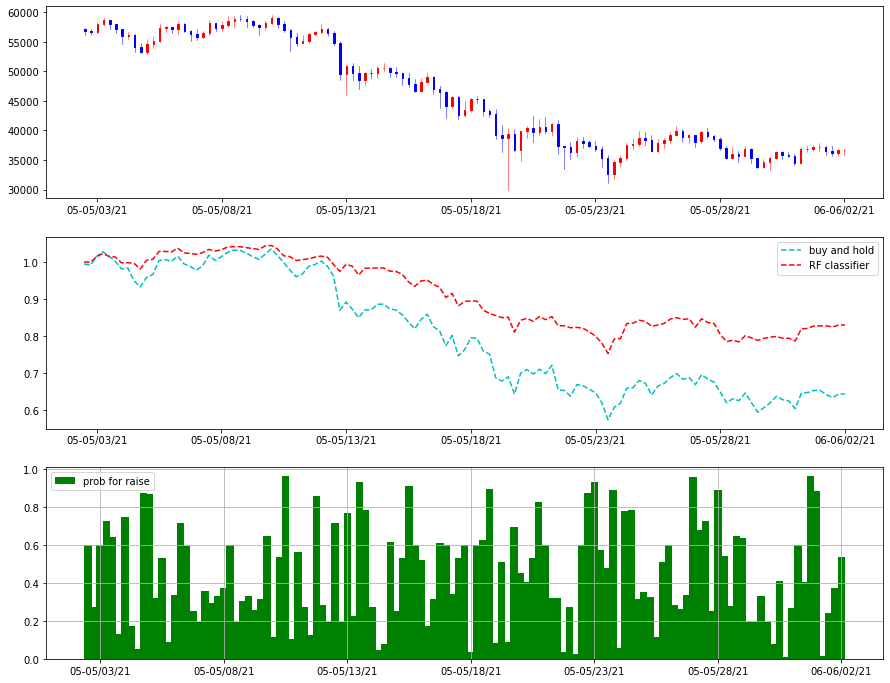

In [23]:
# let's see how the data looks like
ohlc = test_sample[['number', 'open', 'high', 'low', 'close']].copy()

plt.figure(figsize=(15, 12))
p1 = plt.subplot(3, 1, 1)
candlestick_ohlc(p1, ohlc.values, width=0.06, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))

p2 = plt.subplot(3, 1, 2)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.plot(test_sample.number, test_sample.acc_rtn, 'c--', label="buy and hold")
plt.plot(test_book.number, test_book.acc_rtn, 'r--', label='RF classifier')
plt.legend(loc='best')

p3 = plt.subplot(3, 1, 3)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.bar(test_book.number, test_book.weight, color='g', width=0.3, label="prob for raise")
plt.legend(loc='best')
plt.yticks([0., 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(True)
plt.show()